In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import nrrd
import glob

from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
from nibabel.affines import from_matvec, to_matvec, apply_affine
from nibabel.processing import resample_to_output, resample_from_to
import numpy.linalg as npl

In [2]:
# !pip install glob3

## Variables

In [3]:
DATASET = 'KORA' # 'NAKO', 'UKB', 'KORANAKOUKB'
DEFAULT_FILE_TYPE = 'nifti'  # 'nerd'
TARGET_FILE_TYPE = 'nifti'
DEFAULT_ORIENTATION = 'RAS'
TARGET_RESOLUTION = [2,2,3]
DEFAULT_VIEW = ['Saggital', 'Coronal', 'Axial']
DEFAULT_REFERENCE_VIEW = 'Sagittal'
OPTIMIZATION = 'N4'  # Intensity, Min-Max, Fat-Water-Swap
IS_CROPPING = True
DEFAULT_WORLD_COORDS = [500, 500, 1000]
DEFAULT_OUTPUT_PATH = './temp'
DEFAULT_LINSPACE = 30

## Utilities

In [4]:
def create_if_not(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Creating the default paths needed for smooth execution.
create_if_not(DEFAULT_OUTPUT_PATH)

def volume_viewer(vol, axis_idx=0):
    if axis_idx > 2:
        raise Exception('Axis Index cannot be more than 2! Ideally 0: Sagittal, 1: Coronal, 2: Axial.')
    axis = vol.shape
    plt.imshow(vol[axis[axis_idx]//2])
    plt.show()
    
def volume_3_view_viewer(vol):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True)
    axis = vol.shape
    
    ax1.imshow(vol[axis[0]//2])
    ax2.imshow(vol[:, axis[1]//2, :])
    ax3.imshow(vol[:, :, axis[2]//2])
    
    plt.show()
    
def get_volume_data(img):
    print(f"Affine:{img.affine}, Image Shape: {img.shape}")
    return img.get_fdata()

def save_volume(img, file_name):
    nb.save(img, f'{DEFAULT_OUTPUT_PATH}/{file_name}.nii.gz')
    
def sigmoid(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = 1 / (1 + np.exp(-x[i]))
    return y

## Volume Loader / Reader

In [5]:
def nrrd_reader(file_path):
    print("Reading NRRD Files.....")
    _nrrd = nrrd.read(file_path)
    data = _nrrd[0]
    header = _nrrd[1]
    return data, header, None

def nibabel_reader(file_path):
    print("Reading Nifti Files.....")
    volume_nifty = nb.load(file_path)
    volume = get_volume_data(volume_nifty)
    return volume, volume_nifty.header, volume_nifty

def file_reader(file_path, file_type=None):
    print('Reading Files.....')
    header_mat = np.empty_like((4,4))
    if file_type == None:
        file_type = file_path.split('.')[-1]
    if file_type == 'nrrd':
        data, header, img = nrrd_reader(file_path)
        affine = header['space directions']
        affine = affine[:3, :3]
        origins = header['space origin']
        origins = origins[:3]
        t_mat = from_matvec(affine, origins)
        img = nb.Nifti1Image(data, t_mat) if img is None else img
        header_mat = t_mat
    else:
        data, header, img = nibabel_reader(file_path)
        header_mat = header
    
    return data, header_mat, img

def remove_black(volume):
    print("Removing Black Slices.....")
    clean_data = []
    for i, frame in enumerate(volume):
        unique, counts = np.unique(frame, return_counts=True)
        if counts[0] / sum(counts) < .99:
            clean_data.append(frame)
    return np.array(clean_data)

In [6]:
def post_interpolate(volume, labelmap=None, target_shape=[256,256,128]):
    volume = do_cropping(volume, target_shape)
    if labelmap is not None:
        labelmap = do_cropping(labelmap, target_shape)
    current_shape = volume.shape
    intended_shape_deficit = target_shape - np.asarray(current_shape)

    paddings = [tuple(
        np.array([np.ceil((pad_tuples / 2) - pad_tuples % 2), np.floor((pad_tuples / 2) + pad_tuples % 2)]).astype(
            'int32')) for pad_tuples in intended_shape_deficit]
    paddings = tuple(paddings)

    volume = np.pad(volume, paddings, mode='constant')
    if labelmap is not None:
        labelmap = np.pad(labelmap, paddings, mode='constant')

    return volume, labelmap

def do_cropping(source_num_arr, bounding):
    start = list(map(lambda a, da: a // 2 - da // 2, source_num_arr.shape, bounding))
    end = list(map(operator.add, start, bounding))
    for i, val in enumerate(zip(start, end)):
        if val[0] < 0:
            start[i] = 0
            end[i] = source_num_arr.shape[i]
    slices = tuple(map(slice, tuple(start), tuple(end)))
    return source_num_arr[slices]

## Transformation :- Reading Direction Optimization

In [7]:
def do_nibabel_transform_to_ras(img):
    print(f'Transforming Images to {DEFAULT_ORIENTATION}.....')
    affine = img.affine
    orig_ornt = nb.io_orientation(affine)
    targ_ornt = axcodes2ornt(DEFAULT_ORIENTATION)
    transform = ornt_transform(orig_ornt, targ_ornt)
    img = img.as_reoriented(transform)
    return img

def multi_vol_stitching(images, is_label=False):
    if len(images)==1:
        return images
    elif len(images) ==0:
        raise Exception("Empty Image List!")
        
    images_sorted = sorted(images, key=lambda im: im.header['qoffset_z'], reverse=True)
    img_0 = images_sorted[0]
    
    mode = 'nearest' if is_label else 'constant'
    img_0 = resample_to_output(img_0, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    
    for idx, img_1 in enumerate(images_sorted[1:]):
        print(f'{idx}th img for stitching...')
#         print("STARTTTTT: ", img_1.affine)
        img_1 = resample_to_output(img_1, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#         img_1 = placing_axes(img_1, img_0.affine.copy(), img_0.header.copy(), [2])
#         print( img_1.affine)
        target_affine = img_0.affine.copy()
        target_affine[2,3] = img_1.affine[2,3].copy()
        target_shape = img_0.shape[:2] + img_1.shape[2:]
        img_1 = placing_axes(img_1, target_affine, img_0.header.copy(), skip_axis=[2])
        img_1 = resample_from_to(img_1, [target_shape, target_affine])
#         print(img_1.affine)
        img_0 = vol_stitching(img_0, img_1)
#         print(img_0.affine, 'FINISHHHHHHHHH')
        
    return img_0
    
def vol_stitching(im_0, im_1):
    im_0_z = im_0.shape[2]
    im_1_z = im_1.shape[2]

    # calculate overlap region:
    im_0_end = im_0.header['qoffset_z']
    im_1_end = im_1.header['qoffset_z']

    spacing = im_0.header['pixdim'][3]

    im_0_width = im_0_z * spacing
    im_1_width = im_1_z * spacing

    im_1_start = im_1_end + im_1_width
    im_0_start = im_0_end + im_0_width

    overlap = abs(im_0_end - im_1_start)

    overlap_v = int(round(overlap / spacing))

    new_im_dim = abs(round((abs(im_1_end - im_0_start)) / spacing))

    new_img = np.empty([im_0.shape[0], im_0.shape[1], int(new_im_dim)])

    im_0_data = im_0.get_fdata()
    im_1_data = im_1.get_fdata()

    new_img[:, :, 0:(im_1_z - overlap_v)] = im_1_data[:, :, 0:(im_1_z - overlap_v)]
    new_img[:, :, im_1_z:] = im_0_data[:, :, overlap_v:]
    
    # overlap region:
    sigmoid_c = sigmoid(np.linspace(-DEFAULT_LINSPACE, DEFAULT_LINSPACE, overlap_v))
    
    for l in range(0, overlap_v):
        new_img[:, :, (im_1_z - overlap_v + l)] = \
        (1 - sigmoid_c[l]) * im_1_data[:,:, (im_1_z - overlap_v) + l] + (sigmoid_c[l]) * im_0_data[:, :, l]
        
    stitched_img = nb.Nifti1Image(new_img, im_1.affine, im_1.header)
#     placing_axes(stitched_img)
    return stitched_img

def read_ras(file_path, file_type=None):
    _, _, img = file_reader(file_path, file_type)
    img_ras = do_nibabel_transform_to_ras(img)
    return img_ras


def placing_axes(vol, target_affine, target_header=None, skip_axis=None):
    
    vol2target = npl.inv(target_affine).dot(vol.affine)
    source_data = vol.get_fdata()
    shifts = tuple(vol2target[:3, 3].astype(np.int32))
    print(shifts)
#     print(source_data.shape)
    for ax, shift in enumerate(shifts):
        if skip_axis is not None and ax in skip_axis:
            continue
        print(ax, shift)
        shift = int(shift)
        if shift < 0:
            source_data = flip_axis(source_data, axis=ax)
        source_data = np.roll(source_data, shift//2, axis=ax)
                
    if target_header is None:
        target_header = nb.Nifti1Header()
    stitched_labeled_img = nb.Nifti1Image(source_data, target_affine, target_header)

    return stitched_labeled_img

In [8]:
# label = placing_axes(img_ras_sampled_combined_labelmap, img_ras_sampled_combined)
# volume_3_view_viewer(get_volume_data(label))
# save_volume(label, 'kora_label')

## Pre-Processing

STARTING NAKO.
Reading Volumes.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -472.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -664.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -892.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.40625

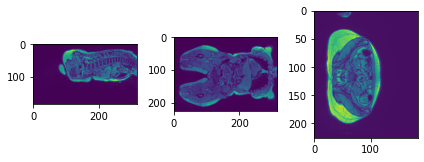

Saving Processed & Stitched Image.....
FINISHED.


In [9]:
print("STARTING NAKO.")
print('Reading Volumes.....')
file_to_read1 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz'
file_to_read2 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz'
file_to_read3 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz'
file_to_read4 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_4.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)
img3_ras = read_ras(file_to_read3)
img4_ras = read_ras(file_to_read4)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras, img3_ras, img4_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'nako_ras_sampled_stitched')
print('FINISHED.')

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
['./datasets/nako/100017_label/100017 _3D_GRE_TRA_opp_3D_GRE_TRA_2_subcutaneous.nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas-2.nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', './datasets/nako/100017_label/100017_3D_GTE_TRA_opp_2_nii_Liver-2-3.nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) .nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_2_nii_Spleen.nrrd', './datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
<class 'n

(-8, -3, 156)
0 -8
1 -3
2 156
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 320 260  96   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.      1.40625 1.40625 3.      1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 320 260  96   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.      1.40625 1.40625 3.      1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset

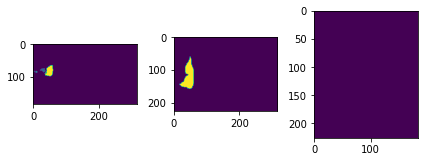

Saving Processed & Stitched Image.....
FINISHED.


In [11]:
volume = img_ras_sampled_combined
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
label_files_to_read_list = glob.glob('./datasets/nako/100017_label/**')
print(label_files_to_read_list)

img_ras_list = []
img_ras_sampled_combined_labelmap = None
header, affine = None, None
for lidx, label_file_to_read in enumerate(label_files_to_read_list):
    img_ras = read_ras(label_file_to_read)
    mode='nearest'
    print(img_ras.header)
    
    target_affine = volume.affine.copy()
#     target_affine[:, 3] = img_ras.affine[:, 3].copy()
    print(volume.affine, target_affine)
    img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    img_ras = placing_axes(img_ras, volume.affine.copy(), volume.header.copy())
    img_ras_sampled = resample_from_to(img_ras, [volume.shape, target_affine])
    
#     img_ras_sampled = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#     print(img_ras_sampled.header)

    labelmap = img_ras_sampled.get_fdata()
    labelmap = np.multiply(lidx, labelmap)
    if header is None or affine is None:
        header = img_ras_sampled.header
        affine = img_ras_sampled.affine
        
    if img_ras_sampled_combined_labelmap is None:
        img_ras_sampled_combined_labelmap = labelmap
    else:
        img_ras_sampled_combined_labelmap = np.add(img_ras_sampled_combined_labelmap, labelmap)
        
img_ras_sampled_combined_labelmap = nb.Nifti1Image(img_ras_sampled_combined_labelmap, affine, header)

print('Merging/Stitching Label-Maps.....')
label = placing_axes(img_ras_sampled_combined_labelmap, volume.affine, volume.header)

print('Viewing Stitched Images.....')

volume_3_view_viewer(get_volume_data(img_ras_sampled_combined_labelmap))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined_labelmap, 'nako_ras_sampled_stitched_labelmap')
print('FINISHED.')

In [ ]:
print("STARTING KORA.")
print('Reading Volumes.....')
file_to_read1 = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz'
file_to_read2 = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'kora_ras_sampled_stitched')
print('FINISHED.')

In [ ]:
# file_structure = [[[v1,v2],[l1,l2,l3,l4,l5,l6,l7,l8],[...]]
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
label_files_to_read_list = glob.glob('./datasets/kora/KORA2460249_label/**')
print(label_files_to_read_list, img_ras_sampled_combined.header)

img_ras_list = []
img_ras_sampled_combined_labelmap = None
header, affine = None, None
for lidx, label_file_to_read in enumerate(label_files_to_read_list):
    img_ras = read_ras(label_file_to_read)
    mode='nearest'
    print(img_ras.header)
    
    target_affine = img_ras_sampled_combined.affine.copy()
    target_affine[:, 3] = img_ras.affine[:, 3].copy()
    print(img_ras_sampled_combined.affine, target_affine)
    img_ras_sampled = resample_from_to(img_ras, [img_ras_sampled_combined.shape, target_affine])
    
#     img_ras_sampled = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    print(img_ras_sampled.header)

    labelmap = img_ras_sampled.get_fdata()
    labelmap = np.multiply(lidx, labelmap)
    if header is None or affine is None:
        header = img_ras_sampled.header
        affine = img_ras_sampled.affine
        
    if img_ras_sampled_combined_labelmap is None:
        img_ras_sampled_combined_labelmap = labelmap
    else:
        img_ras_sampled_combined_labelmap = np.add(img_ras_sampled_combined_labelmap, labelmap)
        
img_ras_sampled_combined_labelmap = nb.Nifti1Image(img_ras_sampled_combined_labelmap, affine, header)
#     img_ras_list.append(img_ras_sampled)

print('Merging/Stitching Label-Maps.....')
# img_ras_sampled_combined_labelmap = multi_vol_stitching(img_ras, True)
# target_affine = img_0.affine.copy()
# target_affine[2,3] = img_1.affine[2,3].copy()
# target_shape = img_0.shape[:2] + img_1.shape[2:]
img_ras_sampled_combined_labelmap_vol = np.flip(np.moveaxis(get_volume_data(img_ras_sampled_combined_labelmap), 2, 1))
img_ras_sampled_combined_labelmap = nb.Nifti1Image(img_ras_sampled_combined_labelmap_vol, img_ras_sampled_combined_labelmap.affine, img_ras_sampled_combined_labelmap.header)
img_ras_sampled_combined_labelmap = resample_from_to(img_ras_sampled_combined_labelmap, [img_ras_sampled_combined.shape, img_ras_sampled_combined.affine.copy()])
# img_ras_sampled_combined_labelmap = nb.funcs.concat_images(img_ras_list, axis=2)
# label = placing_axes(img_ras_sampled_combined_labelmap, img_ras_sampled_combined)

print('Viewing Stitched Images.....')

volume_3_view_viewer(get_volume_data(img_ras_sampled_combined_labelmap))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined_labelmap, 'kora_ras_sampled_stitched_labelmap')
print('FINISHED.')

In [ ]:
print('Viewing Stitched Images.....')
img_ras_sampled_combined_labelmap = np.flip(np.moveaxis(img_ras_sampled_combined_labelmap, 2, 1)) 
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined_labelmap))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined_labelmap, 'kora_ras_sampled_stitched_labelmap')
print('FINISHED.')

In [ ]:
vol = img_ras_sampled_combined
label = img_ras_sampled_combined_labelmap

label = resample_from_to(label, [vol.shape, vol.affine])
print(vol.header, label.header)
# label = multi_vol_stitching([vol, label])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(vol))

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(label))

save_volume(vol, 'kora_final_vol')
save_volume(label, 'kora_final_label')

In [ ]:
print("STARTING UKB.")
print('Reading Volumes.....')
file_to_read1 = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz'
file_to_read2 = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz'
file_to_read3 = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)
img3_ras = read_ras(file_to_read3)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras, img3_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'ukb_ras_sampled_stitched')
print('FINISHED.')

In [ ]:
a = np.arange(12).reshape((3,4))
a

In [ ]:
np.roll(a, 2, axis=0)

In [ ]:
np.roll(a, 1, axis=1)

In [ ]:
np.roll(a, -1, axis=1)